# Generative Model (Wines dataset)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.8


In [2]:
# import local utility functions and classes
import sys
sys.path.append('../utils')
import models as mdl
import utils as utl
from data import Data

## Load raw data and plot

In [3]:
# init data object
data_obj = Data('../../data/wines/FTIR_wines.csv', 'label', -2)
data = data_obj.data
data.head(5)

,932.91,936.765,940.62,944.475,948.33,952.1849999999999,956.04,959.895,963.75,967.605,...,4972.95,4976.805,4980.66,4984.515,4988.37,4992.225,4996.08,4999.935,class,label
37,1.301921,1.311006,1.305213,1.296517,1.286133,1.274641,1.261245,1.247774,1.230944,1.213224,...,1.035489,1.036166,1.037137,1.038021,1.038525,1.038702,1.038639,1.038596,4,SOU
24,1.281646,1.279844,1.273531,1.268430,1.260526,1.251881,1.240449,1.228641,1.214928,1.199532,...,1.018638,1.020133,1.021444,1.021859,1.021668,1.021834,1.022510,1.022804,3,CHI
25,1.276920,1.274866,1.268298,1.262950,1.254863,1.245699,1.235449,1.224469,1.210163,1.194628,...,1.024901,1.025875,1.026429,1.026275,1.026343,1.027218,1.028166,1.028479,3,CHI
36,1.298266,1.292942,1.282317,1.272950,1.262324,1.252790,1.242862,1.233085,1.219276,1.202933,...,1.025911,1.026402,1.027299,1.028218,1.028717,1.029182,1.029756,1.029640,4,SOU
34,1.285827,1.278952,1.268066,1.260775,1.251198,1.242883,1.232692,1.222309,1.208372,1.193019,...,1.006447,1.006938,1.007896,1.009006,1.009892,1.010381,1.010475,1.010322,4,SOU


ARG: blue
AUS: red
CHI: green
SOU: orange


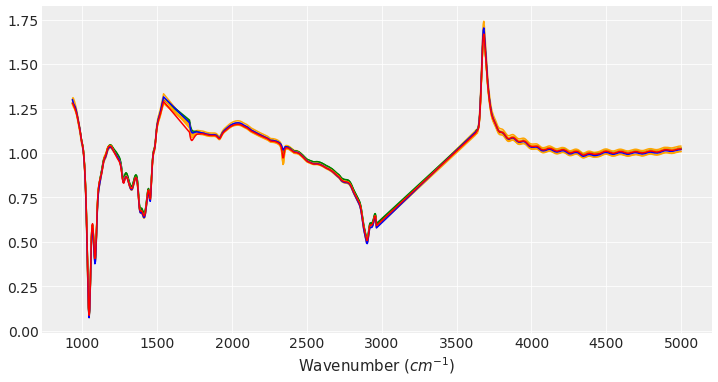

In [4]:
# name of column containing the labels
label_col = data_obj.label_column

# number of non-data columns at right of dataframe
non_data_cols = data_obj.non_data_columns

# list of class labels
class_labels = data_obj.get_class_labels()

# plot dataframe
utl.plot_data(data_obj, 8)

In [5]:
# number of samples from each class
data[label_col].value_counts()

CHI    15
AUS    12
SOU    11
ARG     6
Name: label, dtype: int64

In [6]:
# store the data values for all different classes
df = [data.query("label ==  @class_labels[@i]") for i in range(len(class_labels))]

x_n = data.columns[:non_data_cols]
x_s = [df[i][x_n].values for i in range(len(df))]

# Model definition

The following model is assumed:

\begin{equation}
\mu_{m} \sim \text{LogNormal}(0, 1) \\
\sigma_{ab} \sim \Gamma(1, 1) \\
\sigma_{m} \sim |\mathcal{N}(0, \sigma^{2}_{ab})| \\
\mu \sim \mathcal{N}(\mu_{m},\sigma^{2}_{m}) \\
\sigma_{\sigma} \sim \Gamma(1, 1) \\
\sigma \sim |\mathcal{N}(0, \sigma^{2}_{\sigma})| \\
X_{a..d} \sim \mathcal{N}(\mu,\sigma^{2})
\end{equation}

In [7]:
# load model and run inference
genmod = mdl.generative_model(x_s, len(class_labels), len(x_n))

with genmod:
    trace_gm = pm.sample(2000, init='adapt_diag', tune=1000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, sigma_s, mu, sigma_mu, sigma_ab, mu_m]
Sampling 2 chains, 1 divergences: 100%|██████████| 6000/6000 [01:10<00:00, 85.04draws/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


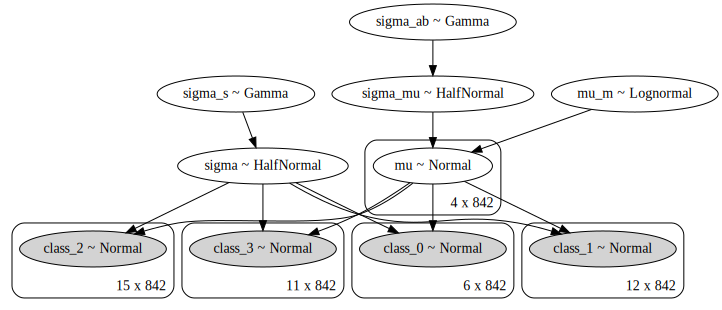

In [8]:
pm.model_to_graphviz(genmod)

In [9]:
az.summary(trace_gm)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"mu[0,0]",1.296,0.005,1.286,1.305,0.000,0.000,3576.0,3576.0,3569.0,2527.0,1.0
"mu[0,1]",1.292,0.005,1.282,1.301,0.000,0.000,4274.0,4274.0,4339.0,2714.0,1.0
"mu[0,2]",1.282,0.005,1.273,1.291,0.000,0.000,5555.0,5554.0,5549.0,2673.0,1.0
"mu[0,3]",1.274,0.005,1.265,1.283,0.000,0.000,3800.0,3800.0,3805.0,2815.0,1.0
"mu[0,4]",1.266,0.005,1.258,1.276,0.000,0.000,5116.0,5116.0,5123.0,2286.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
mu_m,0.999,0.003,0.994,1.005,0.000,0.000,4411.0,4411.0,4411.0,2607.0,1.0
sigma_ab,0.586,0.609,0.061,1.557,0.010,0.007,3523.0,3367.0,5570.0,2913.0,1.0
sigma_mu,0.177,0.002,0.173,0.181,0.000,0.000,5277.0,5277.0,5232.0,2425.0,1.0
sigma_s,0.260,0.456,0.004,1.020,0.008,0.006,3157.0,3157.0,4424.0,3019.0,1.0


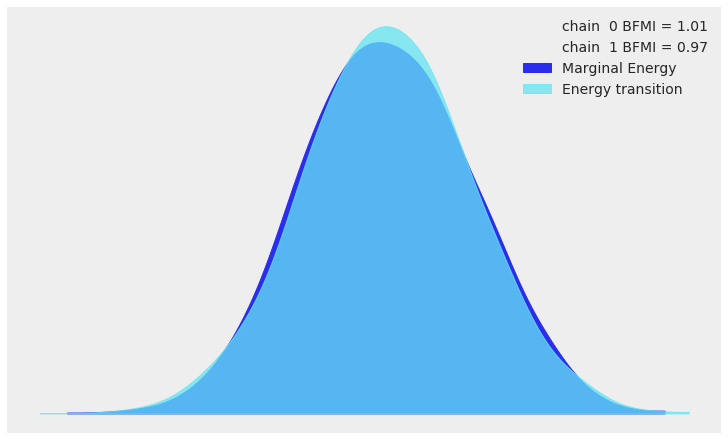

In [10]:
az.plot_energy(trace_gm, figsize=(10, 6));

In [11]:
ppc = pm.sample_posterior_predictive(trace_gm, samples=250, model=genmod)

/home/johan/VirtualEnv/ppsda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 250/250 [00:02<00:00, 99.30it/s] 


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


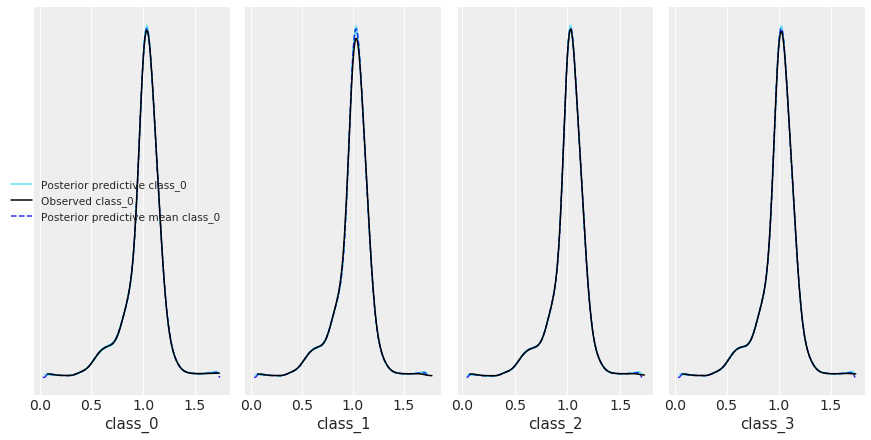

In [12]:
data_ppc = az.from_pymc3(trace=trace_gm, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

In [13]:
print(az.r2_score(x_s[0][:len(x_s[0])], ppc['class_0']))

r2        0.994551
r2_std    0.000495
dtype: float64


In [14]:
print(az.r2_score(x_s[1][:len(x_s[1])], ppc['class_1']))

r2        0.994918
r2_std    0.000452
dtype: float64


In [15]:
print(az.r2_score(x_s[2][:len(x_s[2])], ppc['class_2']))

r2        0.994667
r2_std    0.000473
dtype: float64


In [16]:
print(az.r2_score(x_s[3][:len(x_s[3])], ppc['class_3']))

r2        0.994891
r2_std    0.000460
dtype: float64


In [17]:
print(az.bfmi(trace_gm))

[1.00645204 0.97038182]


# Posterior samples vs. mean data

In [18]:
# class samples from the posterior
cl_a = ppc['class_0']
cl_b = ppc['class_1']
cl_c = ppc['class_2']
cl_d = ppc['class_3']

ppc_class_lst = [cl_a, cl_b, cl_c, cl_d]

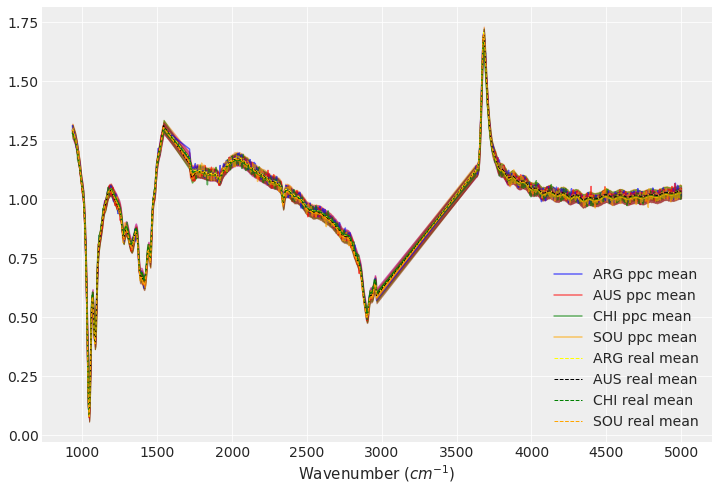

In [19]:
utl.plot_mean_vs_ppc(data_obj, ppc_class_lst)

# Real spectrum vs. posterior samples

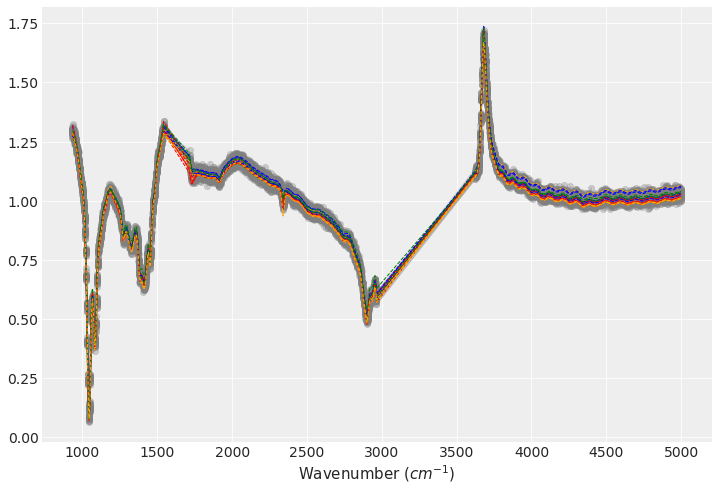

In [20]:
utl.plot_real_vs_ppc(data_obj, ppc_class_lst, 5)

# Save posterior samples to .csv file

In [21]:
utl.save_traces(data_obj, './ppc_samples_wines.csv', 50, ppc_class_lst)